# Drought hazard team SPI output processing

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import geopandas
from shapely.geometry import mapping
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github/percentiles_spi')
import utils

#### BC SWITCH (toggle on / off)

In [2]:
BC_SWITCH = True

## GWL slicing

In [34]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 40fe88fca1eaab8491bb3a5b99167db817b24c65


In [22]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/full_period/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/full_period/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

for input_file in files:
    print(f"---> GWL slicing for {input_file.rpartition('/')[-1]}")
    model_list = ['CMCC-ESM2','ACCESS-ESM1-5','ACCESS-CM2','EC-Earth3','CESM2','CNRM-ESM2-1','MPI-ESM1-2-HR', 'NorESM2-MM'] 
    target_model = [model for model in model_list if model in input_file][0]
    variant_id = utils.data_source['CMIP6'][target_model]['variant-id']
    for GWL in [1.2, 1.5, 2.0, 3.0]:
        print('= GWL'+str(GWL))
        GWL_timeslice = get_GWL_timeslice(xr.open_dataset(input_file),'CMIP6',target_model,variant_id,'ssp370',GWL)

        # write to netcdf in output_dir
        GWL_timeslice.attrs['description'] = f"Standardised Precipitation Index computed using method of McKee et al. 1993 for {target_model} GWL{str(GWL)} using a base period of 1965-2014. Further details in supporting technical documentation."
        GWL_timeslice.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        GWL_timeslice.attrs['comment'] = f"Using data on {input_dir}"
        GWL_timeslice.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
        GWL_timeslice.to_netcdf(f"{output_dir}{input_file.rpartition('/')[-1][:-3]}_GWL{str(GWL)}.nc")

---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_BOM_v1-r1_baseper

## Percent time below SPI < -1

In [4]:
SPI_threshold = -1
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

In [5]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_

In [28]:
print(f"Computing pct time below {str(SPI_threshold)}")
for spi_file in files:
    print(f"-> for {spi_file.rpartition('/')[-1]}")
    spi_xr = xr.open_dataset(spi_file)
    pct_below_thresh = 100*((spi_xr.SPI3)<=SPI_threshold).sum(dim='time')/len(spi_xr.SPI3.time)
    
    # write to netcdf in output_dir
    pct_below_thresh.attrs['description'] = f"Standardised Precipitation Index percent of months below {str(SPI_threshold)} for input file: {spi_file.rpartition('/')[-1]} in {input_dir}. "
    pct_below_thresh.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    pct_below_thresh.attrs['GWL'] = f"GWL {spi_file[-6:-3]}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    pct_below_thresh.to_netcdf(f"{output_dir}{(spi_file.rpartition('/')[-1][:-3])[:5]+'pct_time_below_-1'+(spi_file.rpartition('/')[-1][:-3])[4:]}.nc", mode='w')

Computing pct time below -1
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-

### 10-50-90 Percentiles for GWL and change between GWLs

In [53]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*pct_time_below*baseperiod19652014*{}".format(input_dir, '.nc'))))

In [54]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACC

In [11]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'    

In [41]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file] if BC_SWITCH == False else [file[88:-58] for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    file_name = f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
    p10_50_90_xr.to_netcdf(file_name, mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file] if BC_SWITCH == False else [file[88:-58] for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')

        MME_change = ((MME_xr-MME_GWL12_xr)/MME_GWL12_xr)*100
        MME_change_p10_50_90 = MME_change.quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        file_name = f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        MME_change_p10_50_90.to_netcdf(file_name, mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


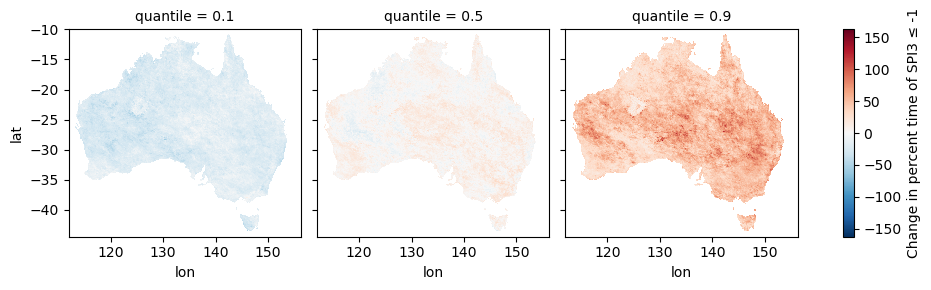

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

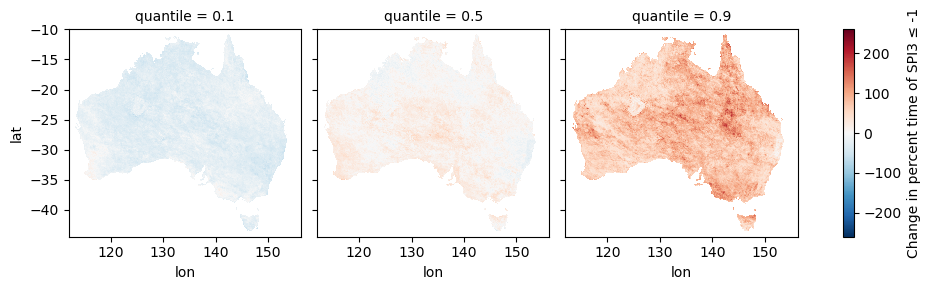

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

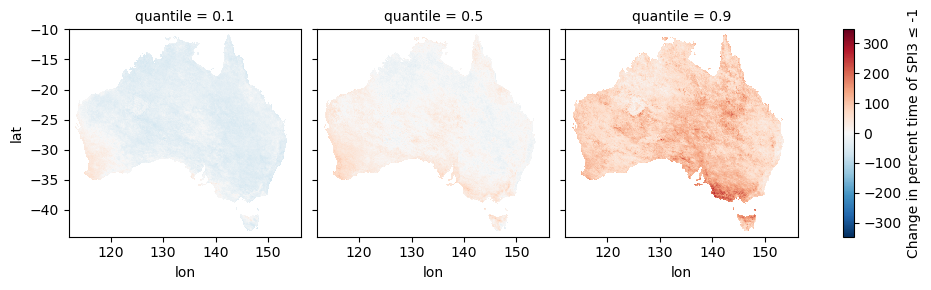

<Figure size 640x480 with 0 Axes>

In [55]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"{output_dir}/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc")
    quick_check_ds.SPI3.plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in percent time of SPI3 ≤ -1'})
    plt.show()
    plt.clf()

## Plotting

In [21]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [22]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

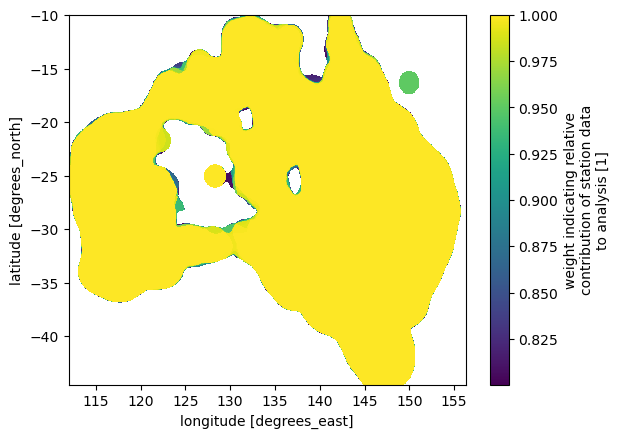

In [23]:
mask_ds = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1975_2005fraction_ge1.nc")
q_mask = np.ma.masked_greater(mask_ds.fraction,0.8)
mask_ds.fraction.where(q_mask.mask).plot()

CPU times: user 1min 21s, sys: 430 ms, total: 1min 22s
Wall time: 1min 22s


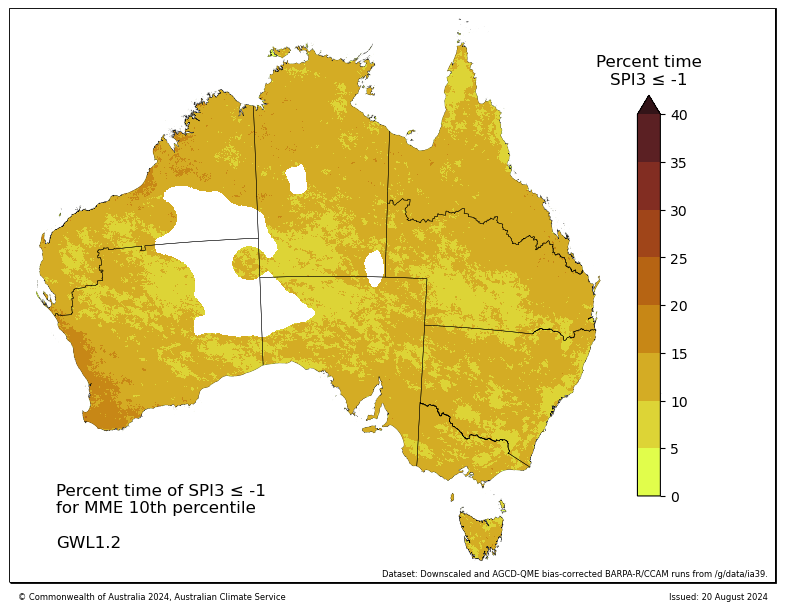

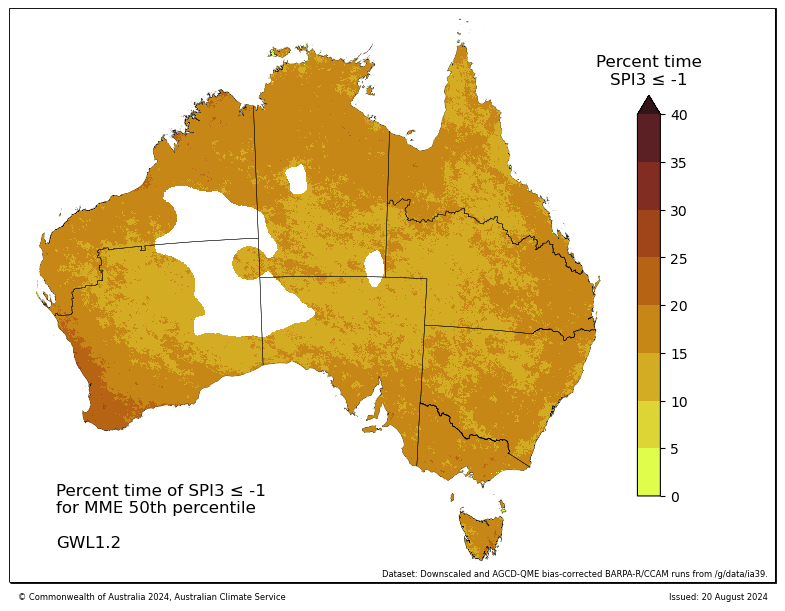

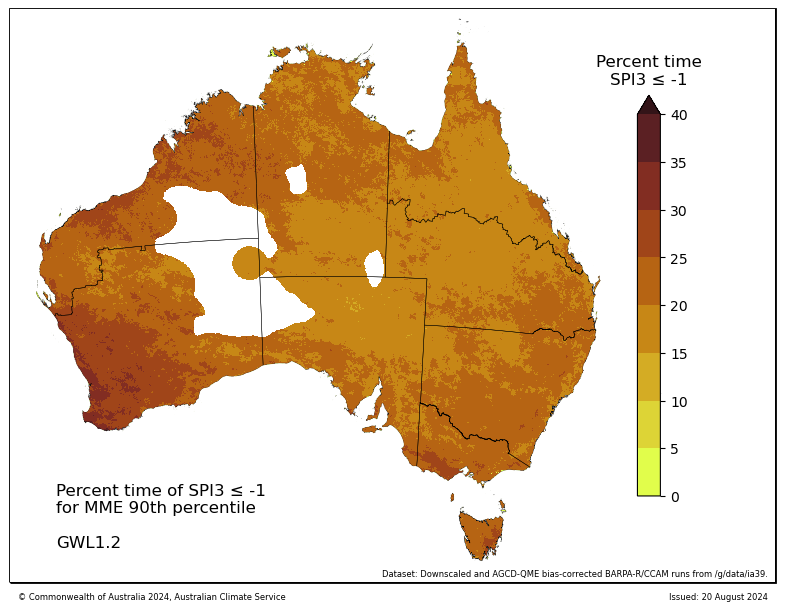

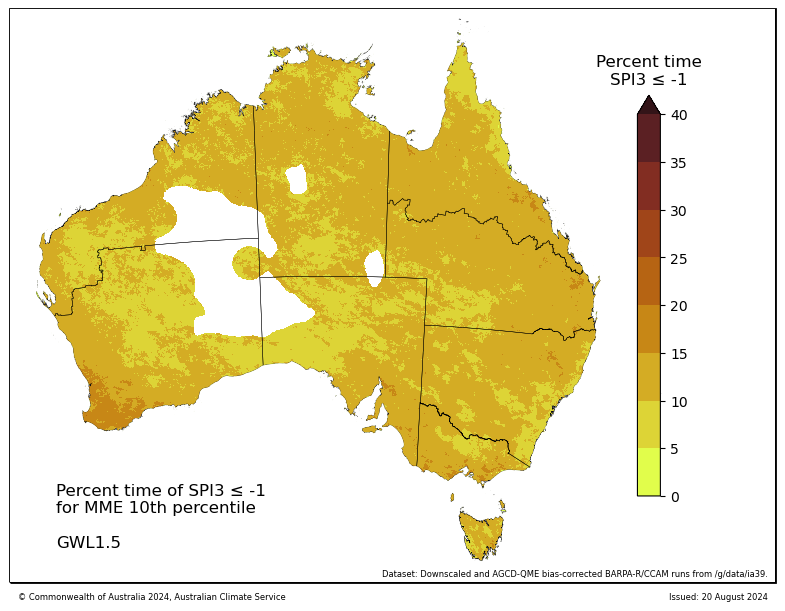

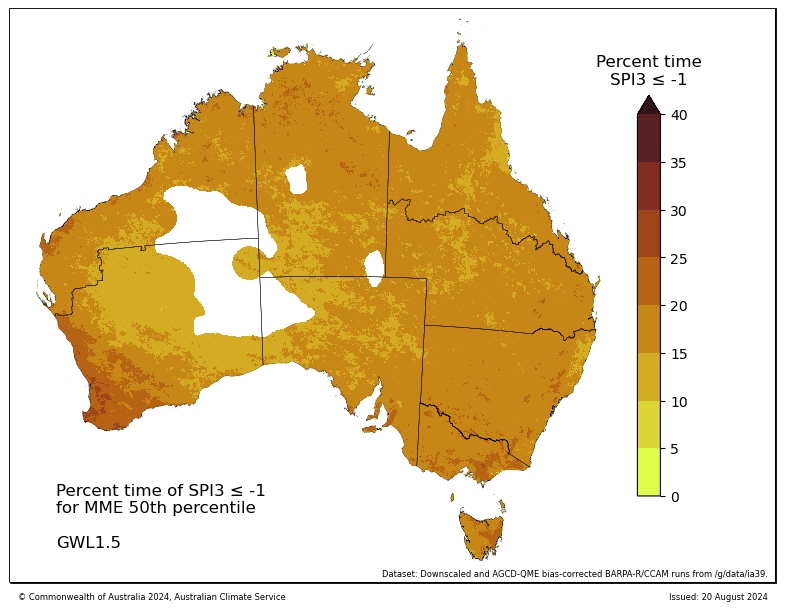

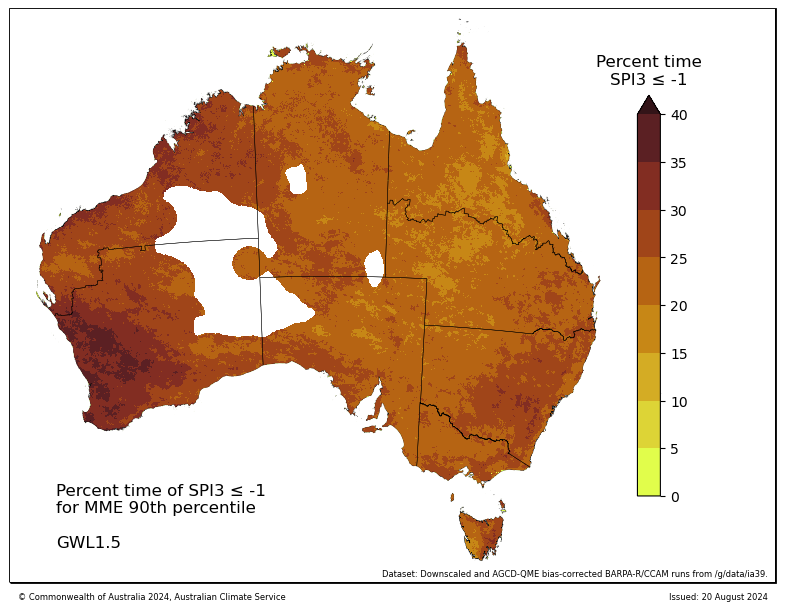

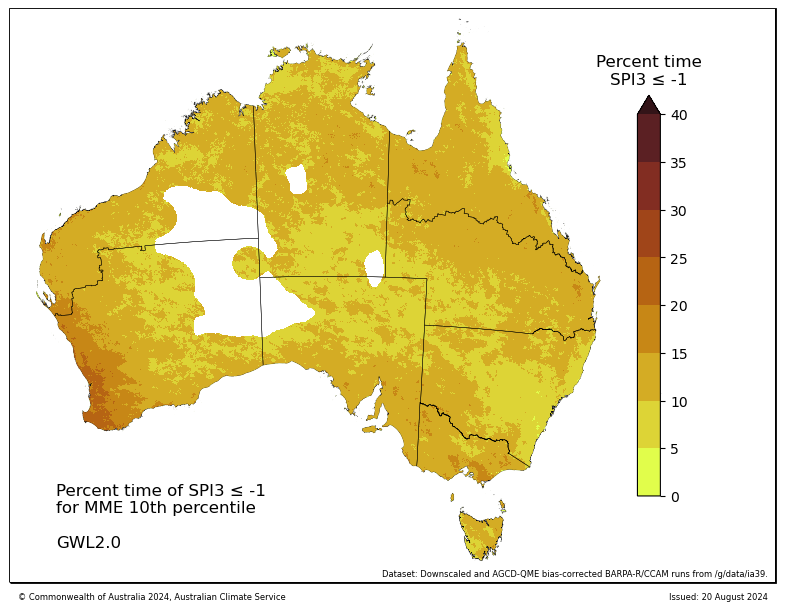

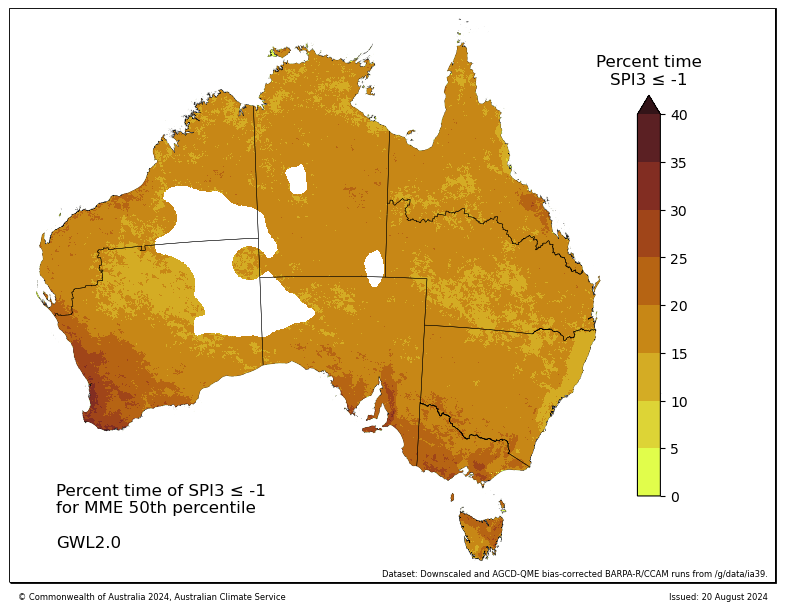

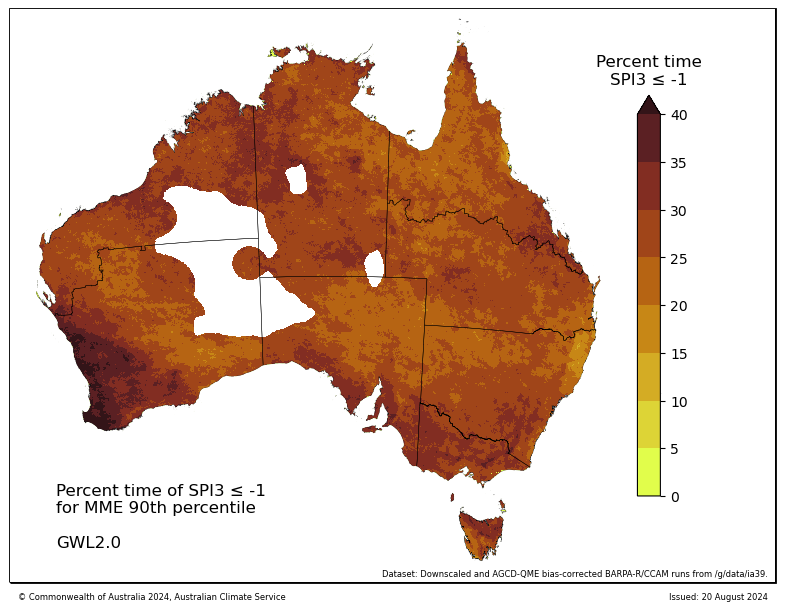

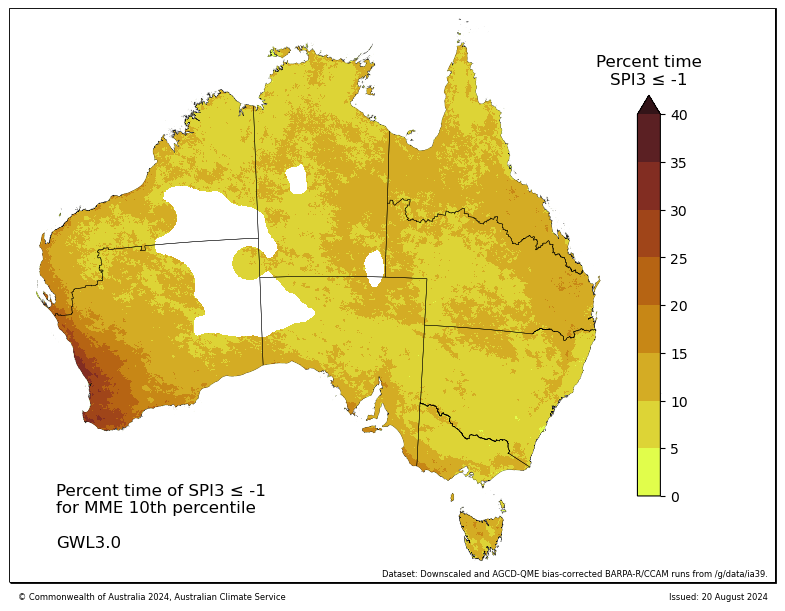

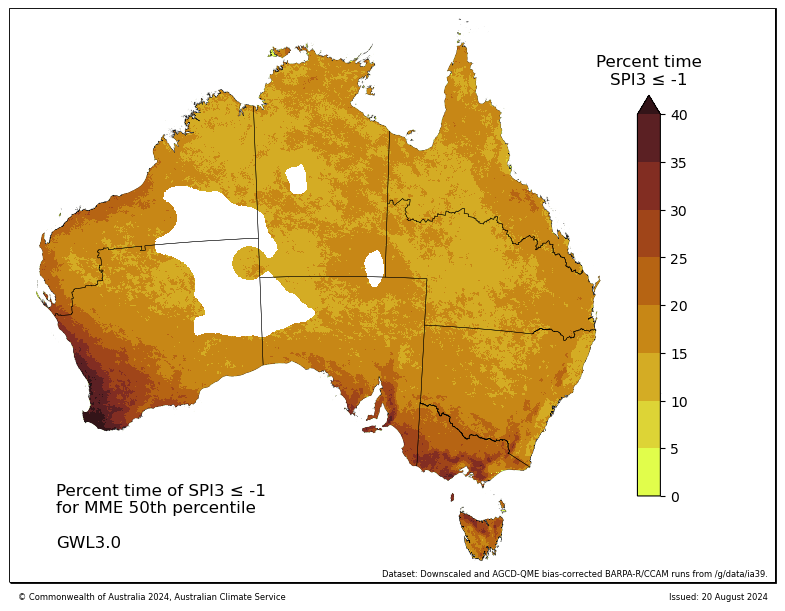

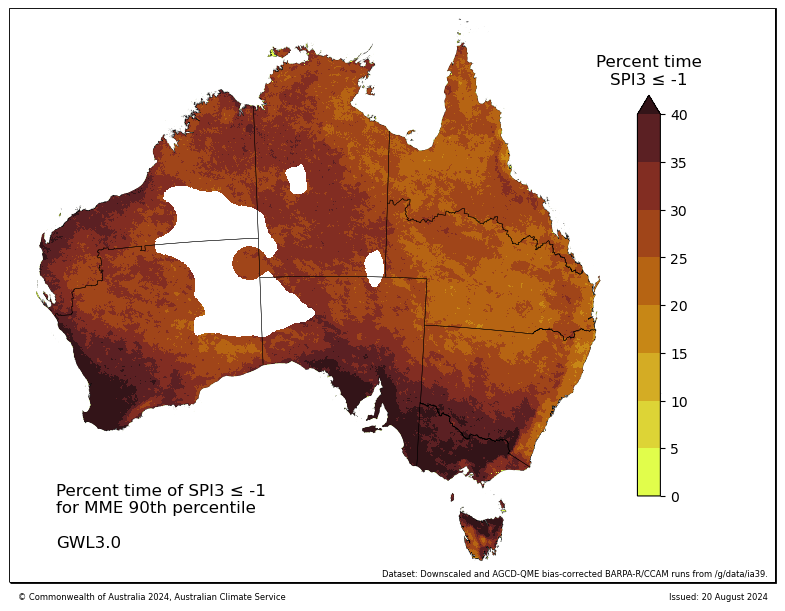

In [26]:
%%time
for GWL in [1.2, 1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        plot_file = f'{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_percentiles_10-50-90.nc' if BC_SWITCH == False else f'{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc'
        
        plot_acs_hazard(data = (xr.open_dataset(plot_file).sel(quantile=percentile).SPI3) if BC_SWITCH == False else (xr.open_dataset(plot_file).sel(quantile=percentile).SPI3).where(q_mask.mask) ,
                        regions = regions_dict['ncra_regions'],
                        cmap = cmap_dict["pr_chance_extremes"],
                        ticks = np.arange(0, 40.1, 5),
                        cbar_label = "Percent time\nSPI3 ≤ -1",
                        cbar_extend = "max",
                        title = f"Percent time of SPI3 ≤ -1\nfor MME {str(int(percentile*100))}th percentile\n",
                        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39." if BC_SWITCH == False else "Downscaled and AGCD-QME bias-corrected BARPA-R/CCAM runs from /g/data/ia39.",
                        date_range = f"GWL{str(GWL)}",
                        contourf = False,
                        contour = False,
                        watermark= None,
                        outfile = f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/figures/SPI3_pct_time_below_-1_GWL{str(GWL)}_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/figures/SPI3_pct_time_below_-1_GWL{str(GWL)}_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}_masked.png"
                    );


CPU times: user 57.6 s, sys: 118 ms, total: 57.7 s
Wall time: 57.7 s


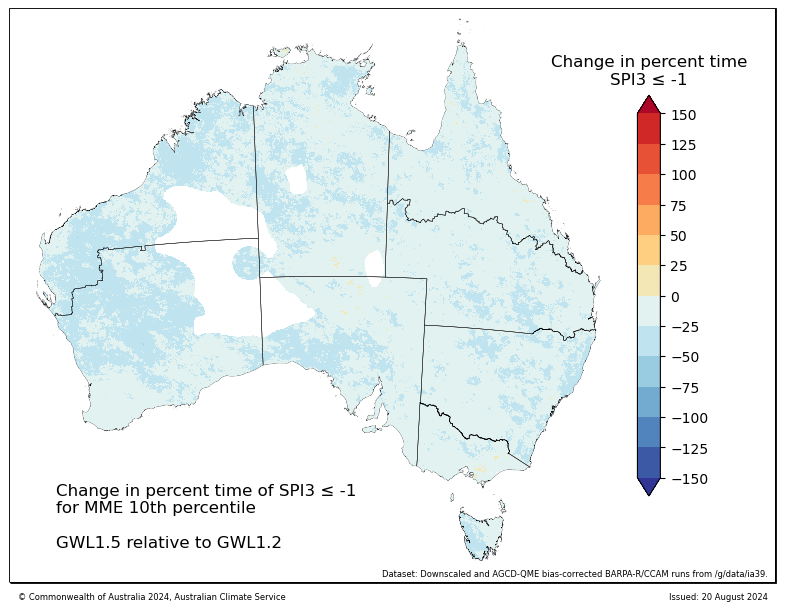

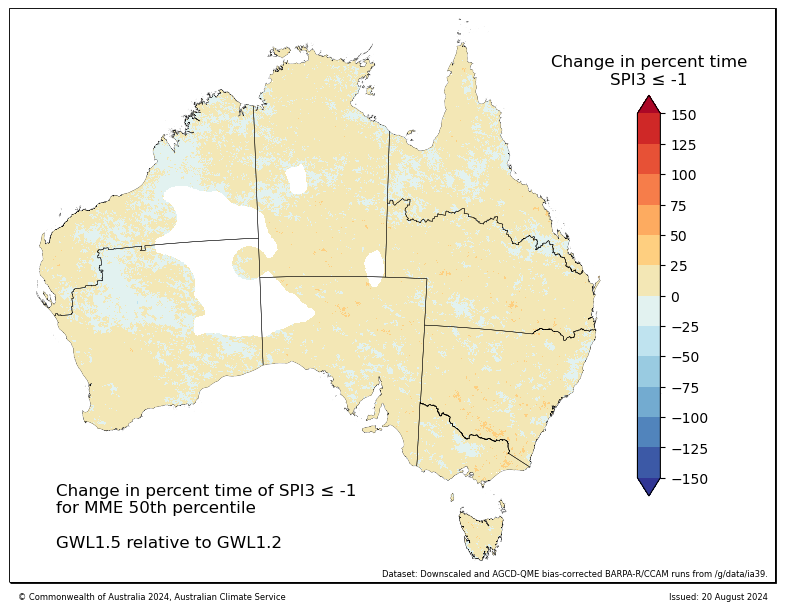

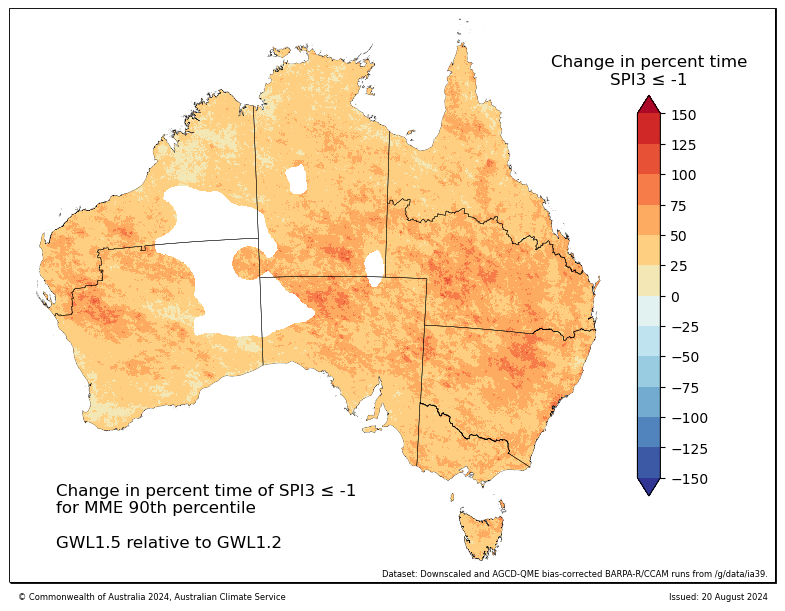

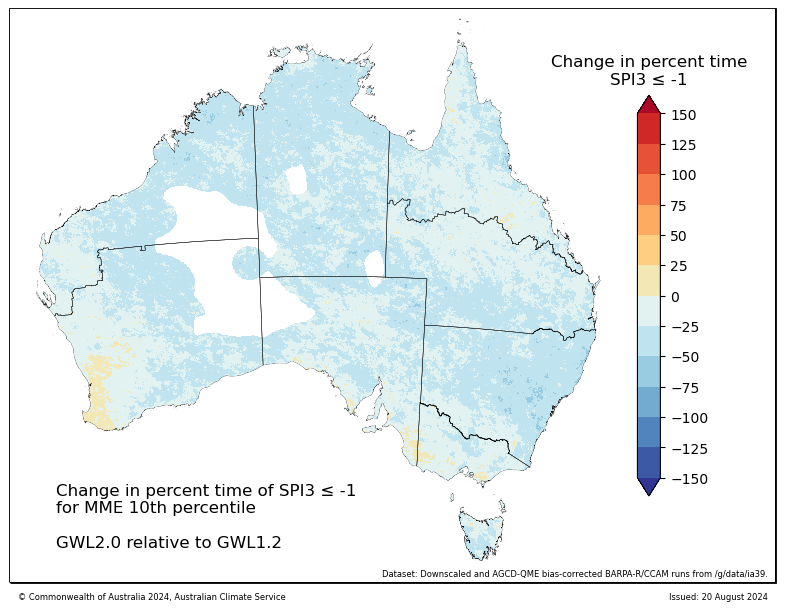

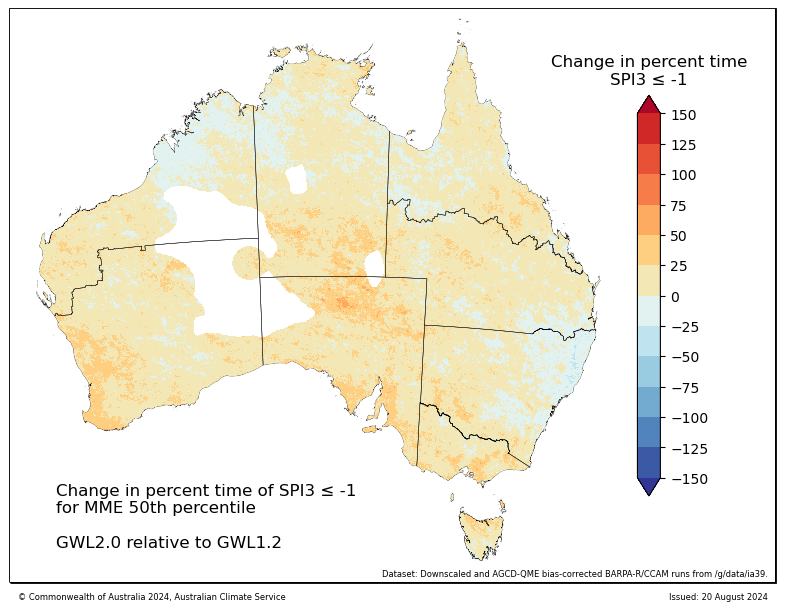

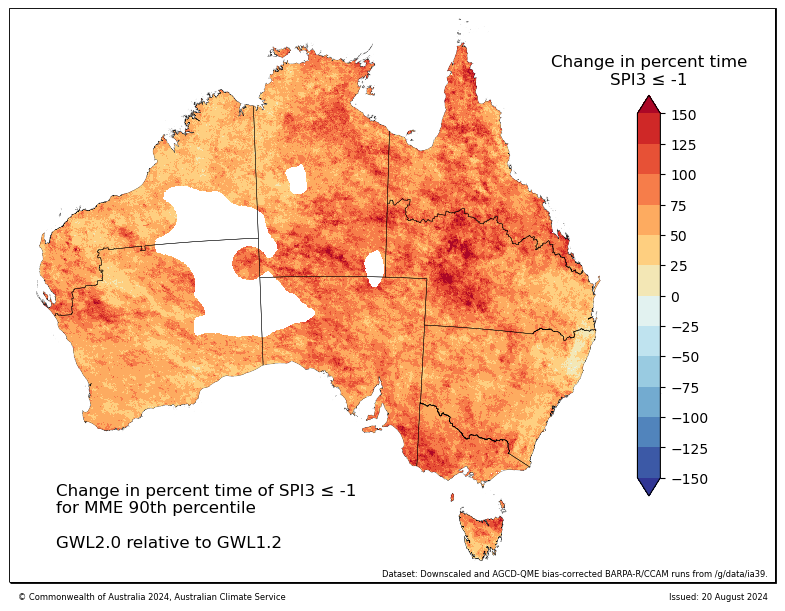

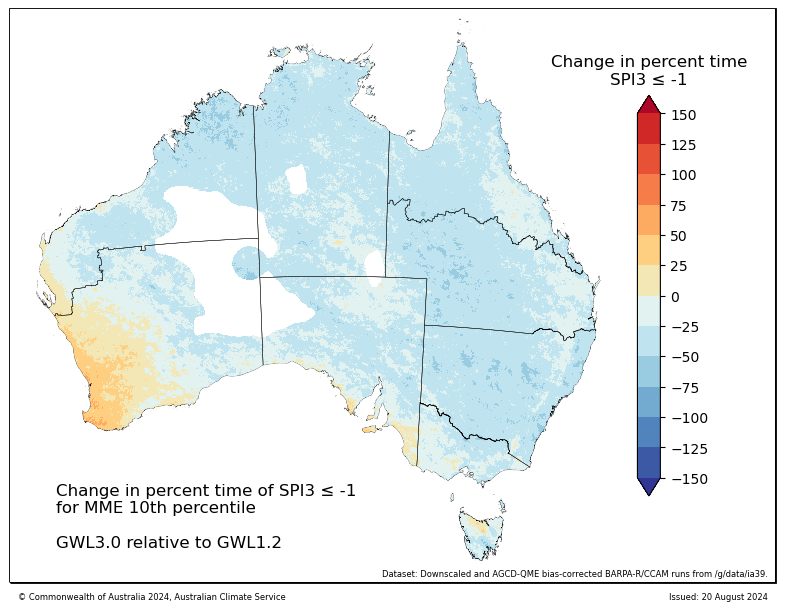

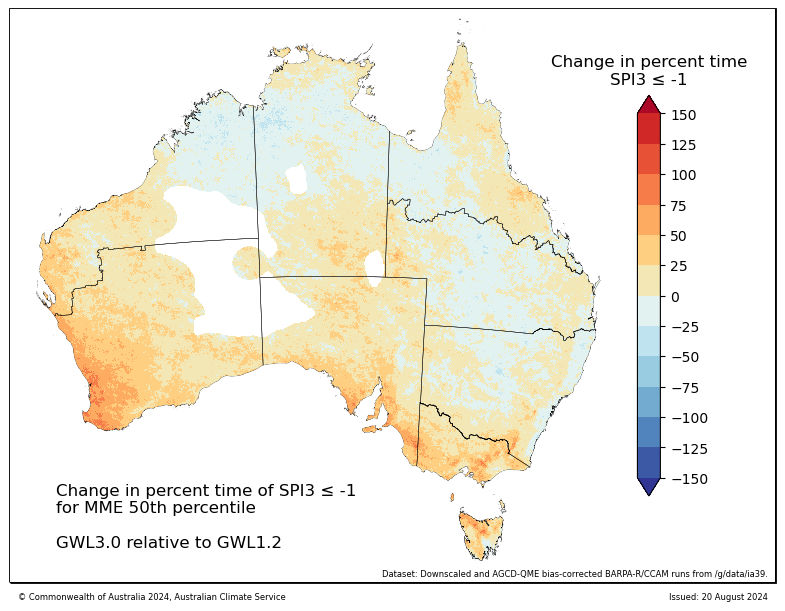

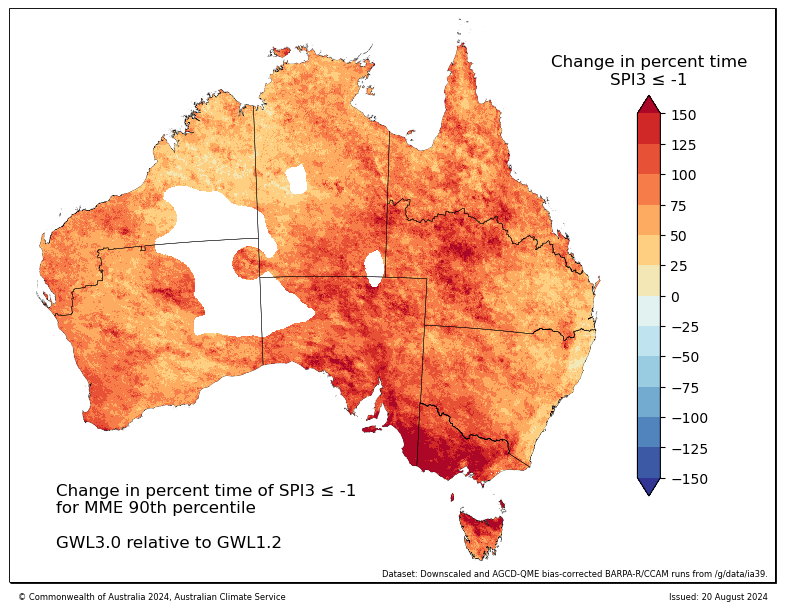

In [27]:
%%time
for GWL in [1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        plot_file = f'{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc' if BC_SWITCH == False else f'{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc'
        
        plot_acs_hazard(data = (xr.open_dataset(plot_file).sel(quantile=percentile).SPI3) if BC_SWITCH == False else (xr.open_dataset(plot_file).sel(quantile=percentile).SPI3).where(q_mask.mask),
                        regions = regions_dict['ncra_regions'],
                        cmap = cmap_dict["anom_b2r"],
                        ticks = np.arange(-150, 150.1, 25),
                        cbar_label = "Change in percent time\nSPI3 ≤ -1",
                        cbar_extend = "both",
                        title = f"Change in percent time of SPI3 ≤ -1\nfor MME {str(int(percentile*100))}th percentile\n",
                        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39." if BC_SWITCH == False else "Downscaled and AGCD-QME bias-corrected BARPA-R/CCAM runs from /g/data/ia39.",
                        date_range = f"GWL{str(GWL)} relative to GWL1.2",
                        contourf = False,
                        contour = False,
                        watermark= None,
                        outfile = f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/figures/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/figures/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}_masked.png"
                       );

## Regional statistics and heatmaps
using IPCC-style method - 'Method 3 - IPCC style' (metric and regional mean for each model, then multi model median)

In [3]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [4]:
from acs_area_statistics import acs_regional_stats, regions

In [5]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*AGCD-05i*{}".format(input_dir, '.nc'))))

In [6]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACC

In [7]:
files_GWL12 = [file for file in files if 'GWL1.2' in file]

In [8]:
def plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    min_max_extent = {1.5:10, 2.0:15, 3.0:20}
    sns.set(font_scale=1.5)
    plt.figure(figsize=(18, 7))
    colors = sns.color_palette("BrBG_r", 12)
    cmap = ListedColormap(colors)
    
    ax = sns.heatmap(plot_df, annot=True, cmap=cmap, linewidth=2, fmt='.1f',
                     cbar_kws={'extend':'both', 'label':'Percent Change (%)'},
                     center=0,
                     vmin=-(min_max_extent[GWL_level]) if variable_colourbar_switch else -150,
                     vmax=(min_max_extent[GWL_level]) if variable_colourbar_switch else 150,
                     yticklabels=list(change_df['abbrevs']),
                     xticklabels=[key[:-5].replace('_', ' ').replace('BOM', 'BARPA').replace('CSIRO', 'CCAM') for key in plot_df.columns])
    
    ax.text(len(plot_df.columns) + 0.85, - 0.5, 'Median' , ha='center', va='center')
    ax.text(len(plot_df.columns) + 0.23, 12, r"$\bf{Bold}$" + ' = at least\n66% of ensemble\nmembers agree on \nsign of the change' , size=16, ha='left', va='center', bbox=dict(boxstyle="round,pad=0.7", edgecolor="black", facecolor="none", linewidth=0.25))
    for i, row in plot_df.iterrows():
        median = row.median()
        sign_agreement = ((row>0).sum()/len(row)) if median > 0 else ((row>0).sum()/len(row))
        fontweight = 'bold' if sign_agreement >= 0.66 else 'normal'
        ax.text(len(plot_df.columns) + 0.85, i + 0.5, f'{median:.1f}', ha='center', va='center', fontweight=fontweight)
        
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([0.83, 0.15, 0.03, 0.7])
    
    ax.set_title(f'Change in time spent in SPI3 ≤ -1 for GWL {str(GWL_level)} relative to GWL 1.2', fontweight='bold', pad=20)
    
    plt.savefig(f'/g/data/mn51/users/jb6465/drought-github/figures/SPI_regional_heatmap_change_GWL{GWL_level}.png', bbox_inches='tight')
    plt.show()
    plt.clf()
    return

---> Plotting GWL1.5 with consistent colourbar across GWLs


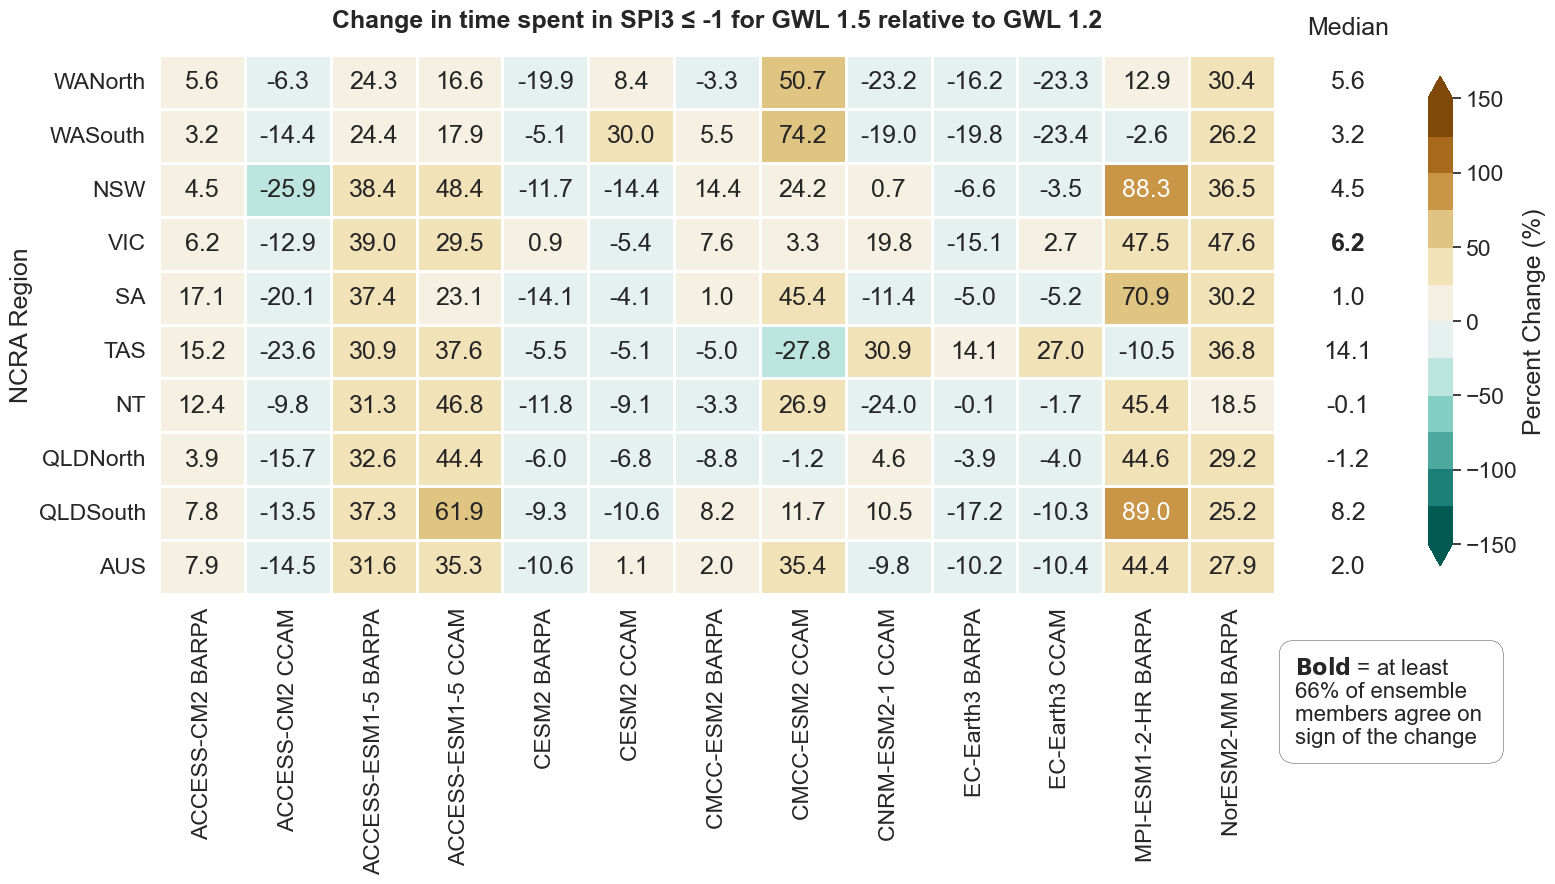

---> Plotting GWL2.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

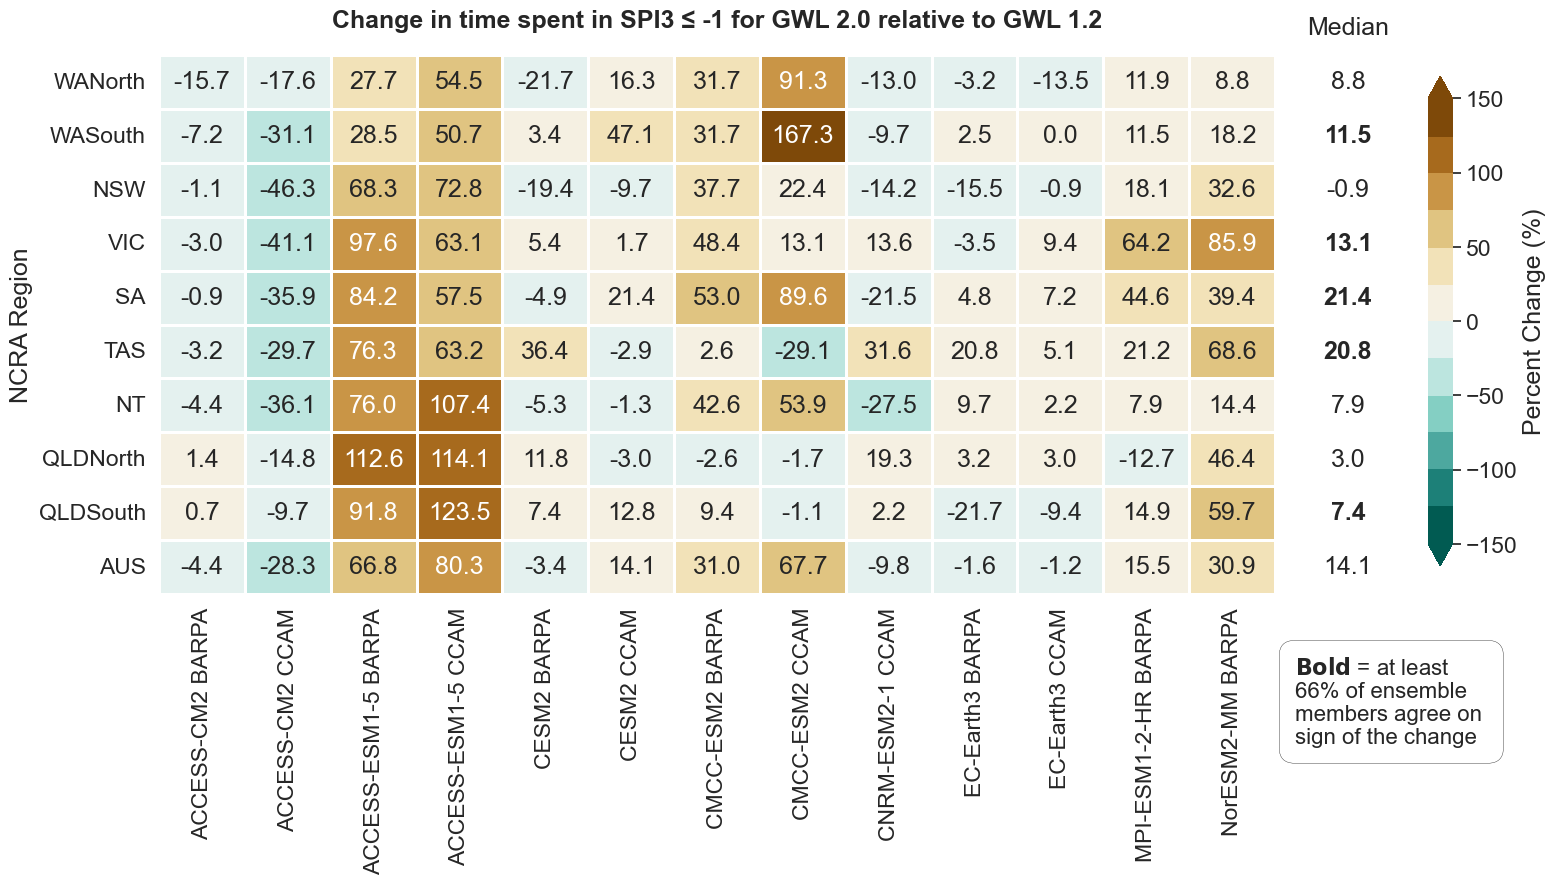

---> Plotting GWL3.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

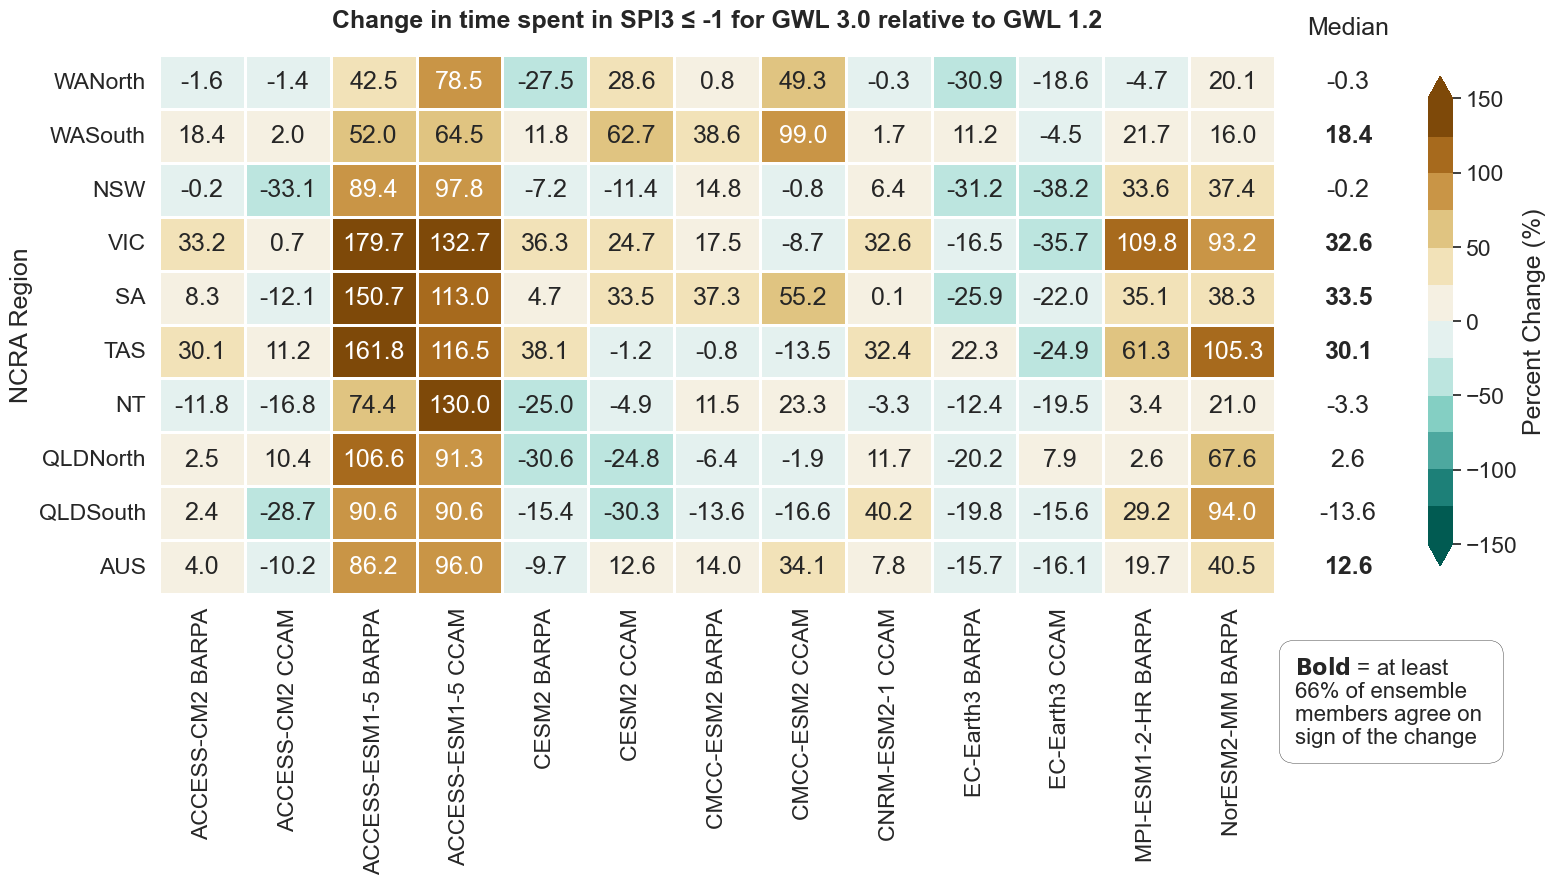

CPU times: user 12min 52s, sys: 1min 6s, total: 13min 59s
Wall time: 13min 59s


<Figure size 640x480 with 0 Axes>

In [9]:
%%time
min_max_extent = {1.5:10, 2.0:15, 3.0:20}

for GWL_level in [1.5, 2.0, 3.0]:
    df_list = []
    for file_GWL12 in files_GWL12:
        file_GWLx = [file for file in files if file_GWL12.split('_')[-8] in file and file_GWL12.split('_')[-5] in file and f'GWL{str(GWL_level)}' in file][0]
    
        ensemble_member_name = file_GWL12.split('_')[-8]+'_'+file_GWL12.split('_')[-5]
        ds_GWLx = xr.open_dataset(file_GWLx)
        ds_GWL12 = xr.open_dataset(file_GWL12)
        GWLx_change = ((ds_GWLx - ds_GWL12)/ds_GWL12*100).rename({'SPI3': ensemble_member_name})      
        mask_frac = regions.mask_3D_frac_approx(GWLx_change)
        dims = ("lat", "lon",)
        change_df = acs_regional_stats(ds=GWLx_change,var=ensemble_member_name, mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe()
        df_list.append(change_df[change_df.columns[-1]])

    plot_df = pd.concat(df_list, axis=1).rename_axis('NCRA Region')
    
    # print(f'---> Plotting GWL{str(GWL_level)} with variable colourbar across GWLs')
    # plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=True)
    
    print(f'---> Plotting GWL{str(GWL_level)} with consistent colourbar across GWLs')
    plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False)


### Do absolute heatmaps with regional mean and multi model median

In [9]:
def plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    min_max_extent = {1.5:10, 2.0:15, 3.0:20}
    sns.set(font_scale=1.5)
    plt.figure(figsize=(18, 7))
    # colors = sns.color_palette("Oranges_r"], 12)
    cmap = cmap_dict["pr_chance_extremes"]#ListedColormap(colors)
    
    ax = sns.heatmap(plot_df, annot=True, cmap=cmap, linewidth=2, 
                     cbar_kws={'extend':'max', 'label':'Percent (%)'},
                     # center=0,
                     vmin=-(min_max_extent[GWL_level]) if variable_colourbar_switch else 0,
                     vmax=(min_max_extent[GWL_level]) if variable_colourbar_switch else 40,
                     yticklabels=list(df['abbrevs']),
                     xticklabels=[key[:-5].replace('_', ' ').replace('BOM', 'BARPA').replace('CSIRO', 'CCAM') for key in plot_df.columns])
    
    ax.text(len(plot_df.columns) + 0.85, - 0.5, 'Median' , ha='center', va='center')
    # ax.text(len(plot_df.columns) + 0.23, 12, r"$\bf{Bold}$" + ' = at least\n70% of ensemble\nmembers agree on \nsign of the change' , size=16, ha='left', va='center', bbox=dict(boxstyle="round,pad=0.7", edgecolor="black", facecolor="none", linewidth=0.25))
    for i, row in plot_df.iterrows():
        median = row.median()
        # sign_agreement = ((row>0).sum()/len(row)) if median > 0 else ((row>0).sum()/len(row))
        # fontweight = 'bold' if sign_agreement >= 0.7 else 'normal'
        ax.text(len(plot_df.columns) + 0.85, i + 0.5, f'{median:.2f}', ha='center', va='center', fontweight='normal')
        
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([0.83, 0.15, 0.03, 0.7])
    
    ax.set_title(f'Time spent in SPI3 ≤ -1 for GWL {str(GWL_level)}', fontweight='bold', pad=20)
    
    plt.show()
    plt.clf()
    return

---> Plotting GWL1.2 with consistent colourbar across GWLs


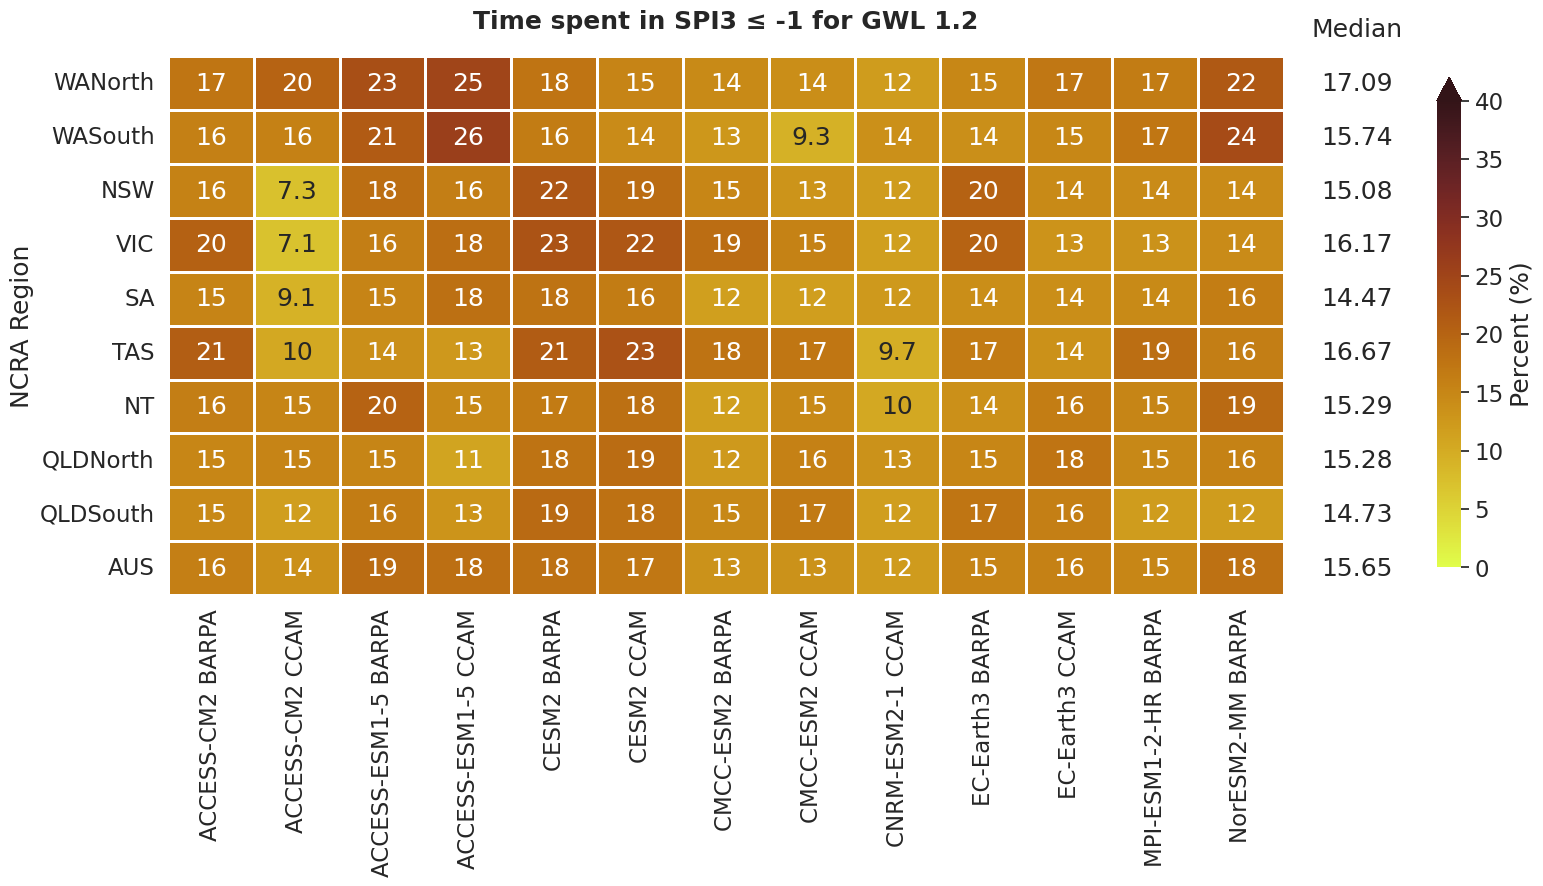

---> Plotting GWL1.5 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

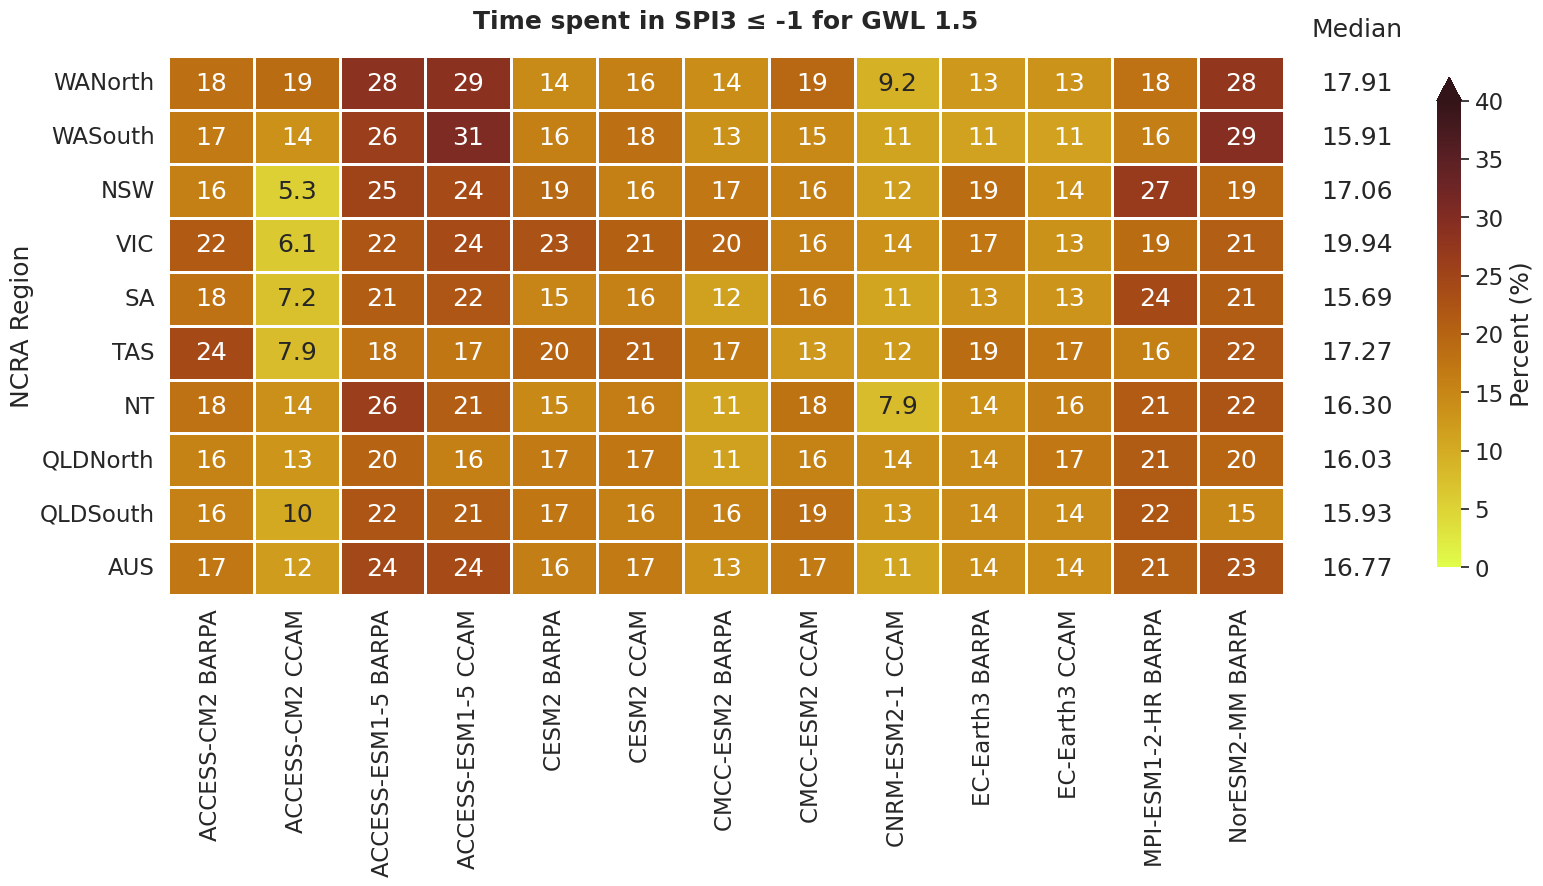

---> Plotting GWL2.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

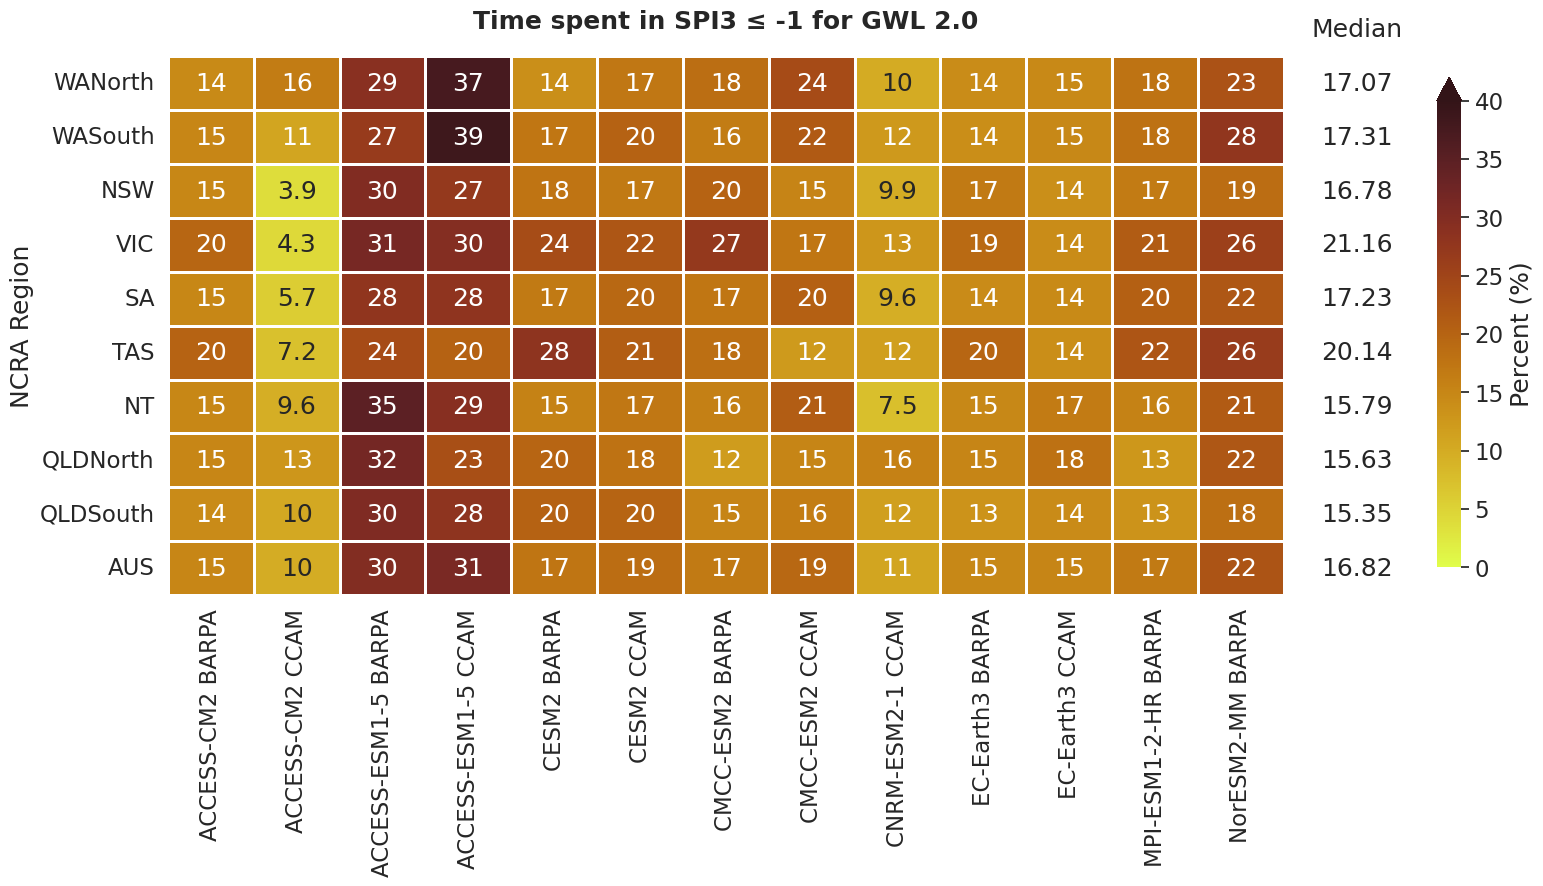

---> Plotting GWL3.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

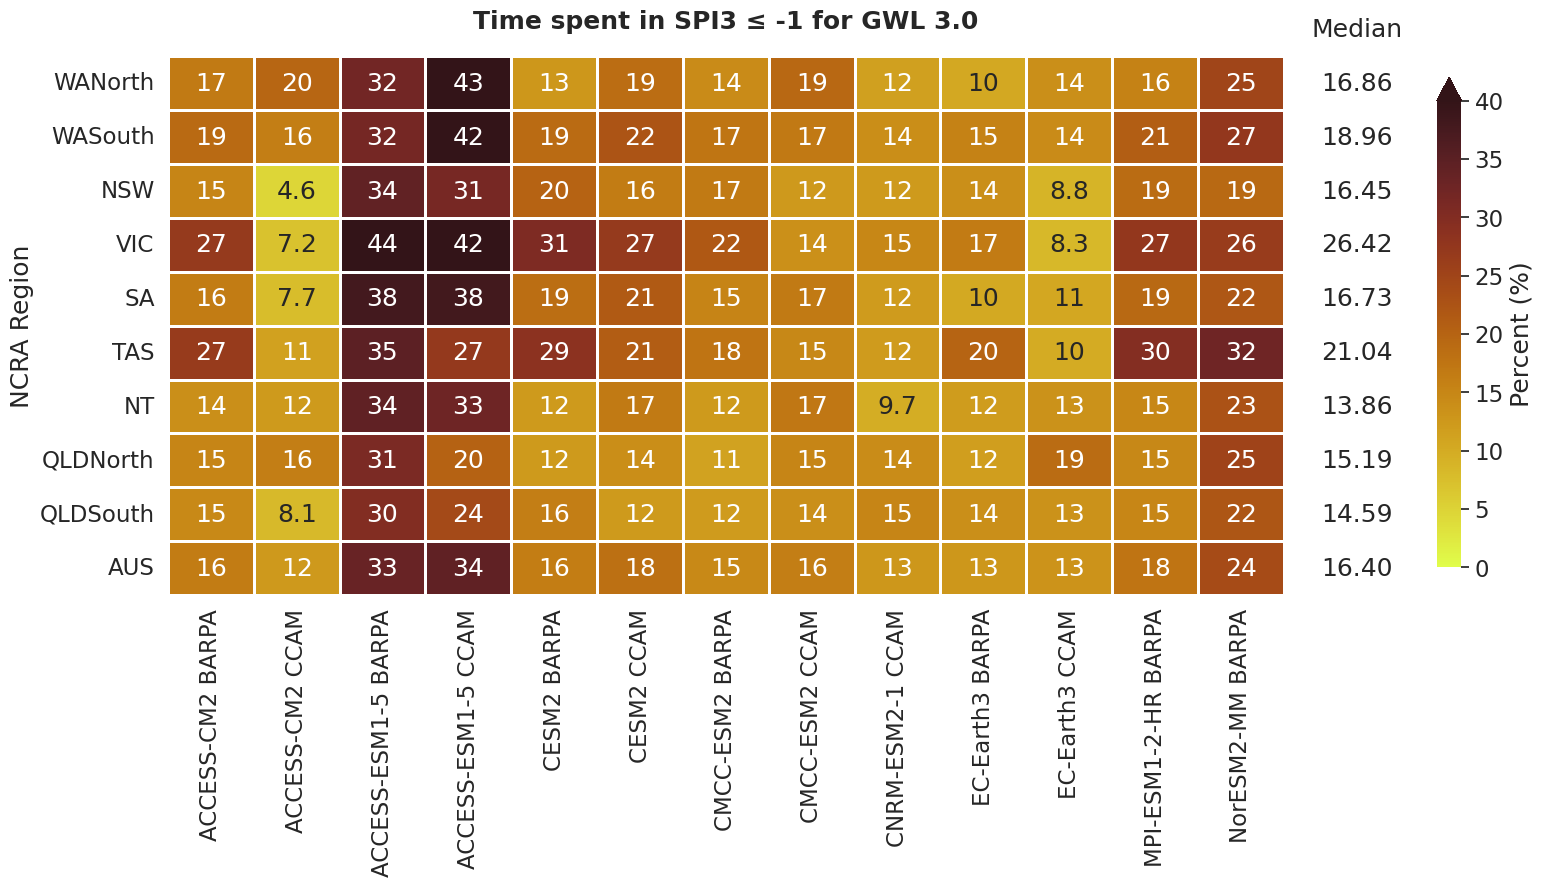

CPU times: user 16min 11s, sys: 1min 34s, total: 17min 45s
Wall time: 17min 51s


<Figure size 640x480 with 0 Axes>

In [10]:
%%time
min_max_extent = {1.5:10, 2.0:15, 3.0:20}

for GWL_level in [1.2, 1.5, 2.0, 3.0]:
    df_list = []
    for file_ in files_GWL12:
        file_GWLx = [file for file in files if file_.split('_')[-8] in file and file_.split('_')[-5] in file and f'GWL{str(GWL_level)}' in file][0]
    
        ensemble_member_name = file_.split('_')[-8]+'_'+file_.split('_')[-5]
        GWLx = xr.open_dataset(file_GWLx).rename({'SPI3': ensemble_member_name})     
        mask_frac = regions.mask_3D_frac_approx(GWLx)
        dims = ("lat", "lon",)
        df = acs_regional_stats(ds=GWLx,var=ensemble_member_name, mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe()
        df_list.append(df[df.columns[-1]])

    plot_df = pd.concat(df_list, axis=1).rename_axis('NCRA Region')
    
    # print(f'---> Plotting GWL{str(GWL_level)} with variable colourbar across GWLs')
    # plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=True)
    
    print(f'---> Plotting GWL{str(GWL_level)} with consistent colourbar across GWLs')
    plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False)
